In [1]:
import time
start = time.time()

import numpy as np
from pickle import load,dump
from esmts25_13 import embed
import scipy.stats as stats 
from statsmodels.stats.multitest import multipletests 
from scipy.fftpack import dct, idct

def dctquant(v,n):
    f = dct(v.T, type=2, norm='ortho')
    trans = idct(f[:,:n], type=2, norm='ortho')
    for i in range(len(trans)):
        trans[i] = scale(trans[i])
    return trans.T

def scale(v):
    M = np.max(v)
    m = np.min(v)
    return (v - m) / float(M - m)

def quant(emb,n=5,m=44):
    dct = dctquant(emb[1:len(emb)-1],n)
    ddct = dctquant(dct.T,m).T
    ddct = ddct.reshape(n*m)
    return (ddct*127).astype('int8')

def quantV2(seq):
    e = embed(seq)
    q25_544 = quant(e[1],5,44)
    q13_385 = quant(e[0],3,85)
    return np.concatenate([q25_544,q13_385])

def embedseq(seq):
    return quantV2(seq)




with open('db/sp.475.v3.quant.pkl','rb') as f:
    db = np.array(load(f))
with open('db/sp.info.fnames.pkl','rb') as f:
    names = np.array(load(f))
    
end = time.time()
print('init',end-start)

/work/LAS/jernigan-lab/mesih/conda/gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


init 7.9480907917022705


In [2]:
outmem = np.zeros((565909, 475))
def search(target,db,names,thr=0.05):
    ldb = len(db)
    mem = outmem[:ldb]
    
    np.subtract(db,target,out=mem)
    np.absolute(mem,out=mem)
    dbdiff = mem.sum(axis=1)
    #dbdiff = np.absolute(db-target).sum(axis=1)
    
    m=np.median(dbdiff)
    s=stats.median_abs_deviation(dbdiff)*1.4826
    zscore = (dbdiff-m)/s
    e = stats.norm.cdf(zscore)*ldb
    res = np.where(e < thr)[0]
    if len(res) == 0: return [],[],[]
    sort = np.argsort(e[res])
    res = res[sort]
    dbdiff = dbdiff[res]/2
    n = names[res]
    
    return e[res].tolist(), dbdiff.tolist(), n.tolist()

In [3]:
hpo30='MPLIMYKFLLVTSIFLIVSGLILTAFSLFSPLWEVVDFPRSHLSHHHGLWWDCIVHHETLIPLHEDQAELRGDRCDSKMDSSVQASLRVALEKGDEEARELLLHRFLPHHKGVIFFAVFTFVFGLISILIGSCSPCFPPNALLYVVGVFMTGACSLLADIIYIFAFNQKPIFTKEQSEPHQEVLSRRERGSIGPIYKRLGIATYMHMFGSMLLIAAFIFSIFCAYFLITSKHAHDVCCTSRKEYREQTKWKNNGLILKTGRVNHQSHRPFVVIDDDSSM'
start = time.time()
hpo30e = embedseq(hpo30)
end = time.time()
print('embed',end-start)

embed 4.082029581069946


In [16]:
%timeit embedseq(hpo30)

966 ms ± 8.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
times = []
lens = []
for i in range(1,101):
    dbt = db[:i*5000]
    namest = names[:i*5000]
    start = time.time()
    search(hpo30e,dbt,namest)
    end = time.time()
    #print(len(dbt),end-start)
    lens.append(i*5000)
    times.append(end-start)

500000 0.3511652946472168


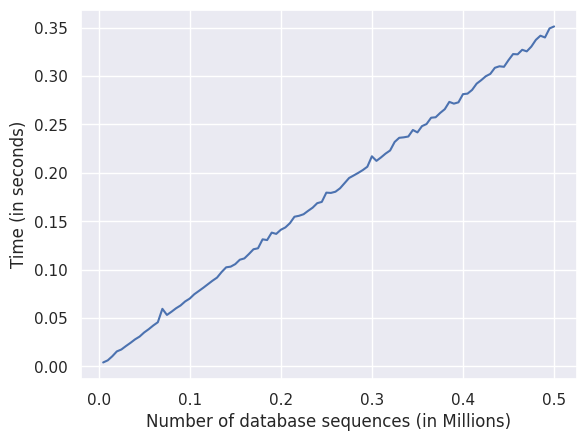

In [9]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
ax =sns.lineplot(x=np.array(lens)/1000000,y=times)
ax.set(xlabel='Number of database sequences (in Millions)',ylabel='Time (in seconds)')
plt.savefig('speed-epyc7543.png', dpi=1200)
plt.savefig('speed-epyc7543.svg')
print(lens[-1],times[-1])